In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch 06. 피마인디언 당뇨병 발병 예측 실습</font><b>

In [2]:
import pandas as pd
import numpy as np
import sys
from tensorflow.keras.utils import to_categorical # 분류 분석 시 y 데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

In [13]:
# 0. 임신횟수
# 1. 2시간내 포도당 농도
# 2. 혈압
# 3. 피부접힘 두께
# 4. 인슐린수치
# 5. BMI체질량지수
# 6. 가족력
# 7. 나이
# 8. 당뇨병발병여부

# 1. 로지스틱 회귀분석(이진분류)
## 1.1. 데이터셋 생성 & 전처리

In [3]:
# 1. csv 파일 데이터프레임으로 읽어오기(결측치 처리, 데이터 균형 확인 목적)
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
df.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       768 non-null    int64  
 1   1       768 non-null    int64  
 2   2       768 non-null    int64  
 3   3       768 non-null    int64  
 4   4       768 non-null    int64  
 5   5       768 non-null    float64
 6   6       768 non-null    float64
 7   7       768 non-null    int64  
 8   8       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.isna().sum() # 열별 결측치 개수

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [5]:
# 타깃변수의 균형
df[8].value_counts()/len(df)

0    0.651042
1    0.348958
Name: 8, dtype: float64

In [ ]:
#df.values
#df.to_numpy()

In [6]:
# 2. csv 파일을 numpy 배열로 읽어오기 (encoding def = cp949) 
# np.loadtxt() #이 있는 행은 제외하고 가져옴
dataset = np.loadtxt('data/pima-indians-diabetes.csv', delimiter=',', encoding='utf-8')
dataset.shape

(768, 9)

In [8]:
# 데이터 분할: 학습 데이터셋(모델 학습용) + 시험 데이터셋(모델 평가용)
X_train = dataset[:620, :-1] # 약 80%
y_train = dataset[:620, -1] # 마지막 열만
X_test = dataset[620:, :-1] # 나머지(약 20%)
y_test = dataset[620:, -1] # 마지막 열만(종속변수)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((620, 8), (620,), (148, 8), (148,))

## 1.2. 모델 구성
X8 → 32 → 16 → y1

In [23]:
model = Sequential()
#model.add(Dense(units=32, input_dim=8, #input_shape=(8,)
#               activation='relu'))
model.add(Input(shape=(8,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='elu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                288       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


## 1.3. 학습 과정 설정
종속변수가 1개에 0 아니면 1이므로 이진분류

In [24]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 1.4. 학습

In [25]:
%%time
hist = model.fit(X_train, y_train, #훈련 데이터셋(학습 데이터셋)
                 epochs=200, 
                 batch_size=310,
                 validation_split=0.1, #검증 데이터 비율(훈련 데이터에서 10%를 검증용 데이터로 구분)
                 verbose=0) # 로그 출력 X
#batch를 나눠도 결과는 거의 동일. 메모리 사이즈에 따라 결정해, batch가 적을수록 속도는 빠를 테니

CPU times: total: 4.91 s
Wall time: 4.42 s


In [13]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 1.5. 모델 평가하기
- 학습과정 시각화하여 살펴보기
- 평가하기
- 교차포(혼동매트릭스, 성능평가지표) 그리기

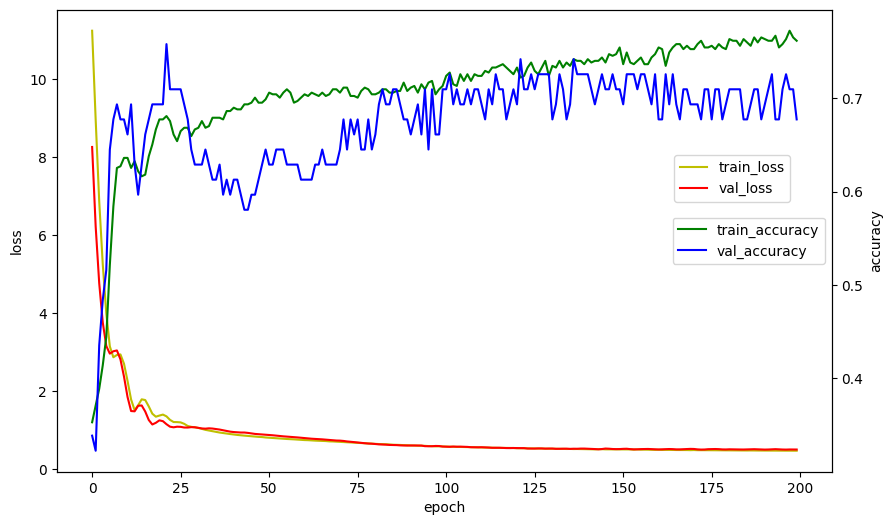

In [26]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [29]:
# 모델 평가
score = model.evaluate(X_test, y_test)
print("loss : {}, 정확도 : {:.2f}".format(score[0], score[1]*100), '%')

5/5 [==============================] - 0s 1ms/step - loss: 0.6693 - accuracy: 0.6824
loss : 0.6693084836006165, 정확도 : 68.24 %


혼동 매트릭스(Confusion Matrix)

<img src='https://velog.velcdn.com/images/leehb9360/post/010a61b8-65d4-48d8-9977-eb2ac4ba363e/image.png'>

- Accuracy(정확도) = ( TP + TN ) / ( TP + FN + FP + TN )
    - 전체 데이터에서 모델이 옳게 판단한 비율<br>
- Precision(정밀도) = TP / ( TP + FP )
    - 양성으로 판단한 데이터 가운데 정확히 판단한 양성의 비율
    - 예측값 기준
- Recall(재현율) = TP / ( TP + FN )
    - 실제 양성인 데이터 가운데 정확히 판단한 양성의 비율
    - 실제 값 기준
- Precision과 Recall은 트레이드오프 관계 - 한 쪽을 높이면 한 쪽이 내려감
- Precision을 높이려면 : 1일 확률이 높은 것만 Positive로 예측함 → recall이 낮아질 수도
- Recall을 높이려면 : 조금이라도 가능성이 있으면 Positive로 예측함 → precision이 낮아질 수도
    - ex.1 암 진단 AI : 
        - Recall ↑, 암환자를 놓치지 않기 위해(FN를 줄임) positive 예측의 폭을 넓힘(재검사가 있으니까)
    - ex.2 금융사기탐지 AI : 
        - Recall 높여 사기일 가능성이 조금만 있어도 사기로 예측 → 고객 불만 증가
        - Precision 높이면(FP를 줄이면) FN이 늘어나 → 기업의 비용 증가
- F1 Score = 2 * Precision * Recall / ( Precision + Recall )
    - Precision과 Recall의 조화평균

In [35]:
# 교차표(혼동매트릭스, 성능평가지표) 그리기 : 테스트셋의 실제값과 예측값
y_hat = (model.predict(X_test) >= 0.5).astype(int)
y_test.shape, y_hat.shape #실제값:1차원, 예측값:2차원

5/5 [==============================] - 0s 1ms/step


((148,), (148, 1))

In [36]:
# 직접 그려 보기
TN = 0; FP = 0; FN = 0; TP = 0;
for y, h in zip(y_test, y_hat.reshape(-1)): #reshape 해서 148행 1열 2차원 → 148행 1차원
    if y==0 and h==0:
        TN += 1
    elif y==0 and h==1:
        FP += 1
    elif y==1 and h==0:
        FN += 1
    else:
        TP += 1
print(TN, FP)
print(FN, TP)

74 22
25 27


In [40]:
# 라이브러리 사용하기 (pandas crosstab)
ctab = pd.crosstab(y_test, y_hat.reshape(-1)) #1차원 넣어야 해
ctab.index.name = '실제값'
ctab.columns.name = '예측값'
ctab

예측값,0,1
실제값,,
0.0,74,22
1.0,25,27


In [41]:
pd.crosstab(y_test, #실제값
            y_hat.reshape(-1), #예측값
            rownames=['실제값'], #index이름
            colnames=['예측값']) #column이름
# 결과가 데이터프레임

예측값,0,1
실제값,,
0.0,74,22
1.0,25,27


In [42]:
# 라이브러리 사용하기 (sklearn confusion_matrix)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_hat) #y_hat.reshape(-1) 둘 다 가능
# 결과가 numpy 배열인 혼동 행렬

array([[74, 22],
       [25, 27]], dtype=int64)

## 1.6. 모델 사용 / 예측, 저장

In [43]:
X_test[0]

array([  2.   , 112.   ,  86.   ,  42.   , 160.   ,  38.4  ,   0.246,
        28.   ])

In [45]:
(model.predict([[2, 112, 86, 42, 160, 38.4, 0.246, 28]]) > 0.5).astype(int)

1/1 [==============================] - 0s 39ms/step


array([[0]])

In [46]:
(model.predict([[2, 112, 86, 42, 160, 38.4, 0.246, 28],
               [1, 115, 86, 42, 160, 38.4, 0.246, 60]]) > 0.5).astype(int)

1/1 [==============================] - 0s 40ms/step


array([[0],
       [1]])

In [47]:
#저장하기 1
model.save('model/06_binary.h5')

In [51]:
#저장하기 2
from tensorflow.keras.models import save_model, load_model
save_model(model, 'model/06_binary.h5')

In [52]:
model2 = load_model('model/06_binary.h5')

In [53]:
(model2.predict([[2, 112, 86, 42, 160, 38.4, 0.246, 28]]) > 0.5).astype(int)

1/1 [==============================] - 0s 50ms/step


array([[0]])

# 2. 분류분석

1. 데이터 생성 및 전처리: 
    - 훈련셋 600, 검증셋 100, 테스트셋 68 분리, 타깃변수 원핫인코딩
2. 모델 생성 (input 8, output 2):
    - [1,0] or [0,1]
    - 출력층의 활성화 함수 : softmax
3. 모델 학습 과정:
    - loss = 'categorical_crossentropy', metrics=['accuracy']
4. 모델 학습:
    - validation_data = [X_val, Y_val]
5. 모델 학습 평가
6. 모델 사용
    - 예측 시 argmax() 함수 활용 - [0.99, 0.01]처럼 나오니까

## 2.1. 데이터셋 생성 & 전처리

In [55]:
df = pd.read_csv('data/pima-indians-diabetes.csv', comment='#', header=None)
dataset = df.values
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [56]:
# 훈련셋 600, 검증셋 100, 테스트셋 68개
X_train = dataset[:600, :-1]
y_train = dataset[:600, -1]
X_val = dataset[600:700, :-1]
y_val = dataset[600:700, -1]
X_test = dataset[700:, :-1]
y_test = dataset[700:, -1]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((600, 8), (600,), (100, 8), (100,), (68, 8), (68,))

In [61]:
# 분류분석을 위한 타깃(종속)변수의 원핫인코딩
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val, 2)
Y_test = to_categorical(y_test)
Y_train.shape, Y_val.shape, Y_test.shape

((600, 2), (100, 2), (68, 2))

In [60]:
print('원 데이터:\n', y_train[:3])
print('원핫인코딩 데이터:\n', Y_train[:3])

원 데이터:
 [1. 0. 1.]
원핫인코딩 데이터:
 [[0. 1.]
 [1. 0.]
 [0. 1.]]


## 2.2. 모델 생성(input 8, target 2)

In [62]:
model = Sequential()
model.add(Dense(units=32, input_shape=(8,), activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                288       
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


## 2.3. 학습 과정 설정

In [63]:
model.compile(loss='categorical_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])

## 2.4. 모델 학습

In [64]:
hist = model.fit(X_train, Y_train, 
                 epochs=200, 
                 validation_data=(X_val, Y_val), 
                 verbose=1)

Epoch 1/200
19/19 [==============================] - 1s 8ms/step - loss: 14.1482 - accuracy: 0.3750 - val_loss: 8.0793 - val_accuracy: 0.3800
Epoch 2/200
19/19 [==============================] - 0s 2ms/step - loss: 5.3399 - accuracy: 0.4800 - val_loss: 3.7233 - val_accuracy: 0.4800
Epoch 3/200
19/19 [==============================] - 0s 2ms/step - loss: 3.0799 - accuracy: 0.4850 - val_loss: 2.3944 - val_accuracy: 0.4700
Epoch 4/200
19/19 [==============================] - 0s 2ms/step - loss: 2.0235 - accuracy: 0.4917 - val_loss: 1.5980 - val_accuracy: 0.4000
Epoch 5/200
19/19 [==============================] - 0s 2ms/step - loss: 1.3283 - accuracy: 0.4717 - val_loss: 1.0345 - val_accuracy: 0.4000
Epoch 6/200
19/19 [==============================] - 0s 3ms/step - loss: 0.9482 - accuracy: 0.4767 - val_loss: 0.8502 - val_accuracy: 0.4500
Epoch 7/200
19/19 [==============================] - 0s 2ms/step - loss: 0.8376 - accuracy: 0.4733 - val_loss: 0.7926 - val_accuracy: 0.4800
Epoch 8/200


Epoch 59/200
19/19 [==============================] - 0s 2ms/step - loss: 0.5666 - accuracy: 0.7167 - val_loss: 0.6476 - val_accuracy: 0.5900
Epoch 60/200
19/19 [==============================] - 0s 2ms/step - loss: 0.5634 - accuracy: 0.7267 - val_loss: 0.6351 - val_accuracy: 0.6700
Epoch 61/200
19/19 [==============================] - 0s 2ms/step - loss: 0.5661 - accuracy: 0.7217 - val_loss: 0.6443 - val_accuracy: 0.6700
Epoch 62/200
19/19 [==============================] - 0s 3ms/step - loss: 0.5675 - accuracy: 0.7300 - val_loss: 0.6579 - val_accuracy: 0.5800
Epoch 63/200
19/19 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7183 - val_loss: 0.6355 - val_accuracy: 0.7100
Epoch 64/200
19/19 [==============================] - 0s 2ms/step - loss: 0.5606 - accuracy: 0.7217 - val_loss: 0.6442 - val_accuracy: 0.6900
Epoch 65/200
19/19 [==============================] - 0s 2ms/step - loss: 0.5726 - accuracy: 0.7283 - val_loss: 0.6291 - val_accuracy: 0.6700
Epoch 

19/19 [==============================] - 0s 3ms/step - loss: 0.4828 - accuracy: 0.7767 - val_loss: 0.5593 - val_accuracy: 0.7200
Epoch 174/200
19/19 [==============================] - 0s 2ms/step - loss: 0.4753 - accuracy: 0.7633 - val_loss: 0.5788 - val_accuracy: 0.6900
Epoch 175/200
19/19 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.7783 - val_loss: 0.5673 - val_accuracy: 0.7000
Epoch 176/200
19/19 [==============================] - 0s 2ms/step - loss: 0.4777 - accuracy: 0.7817 - val_loss: 0.6155 - val_accuracy: 0.6700
Epoch 177/200
19/19 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.7550 - val_loss: 0.5532 - val_accuracy: 0.7200
Epoch 178/200
19/19 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.7683 - val_loss: 0.6126 - val_accuracy: 0.6900
Epoch 179/200
19/19 [==============================] - 0s 2ms/step - loss: 0.4748 - accuracy: 0.7767 - val_loss: 0.5638 - val_accuracy: 0.7100
Epoch 180/200

## 2.5. 모델 평가하기

In [66]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

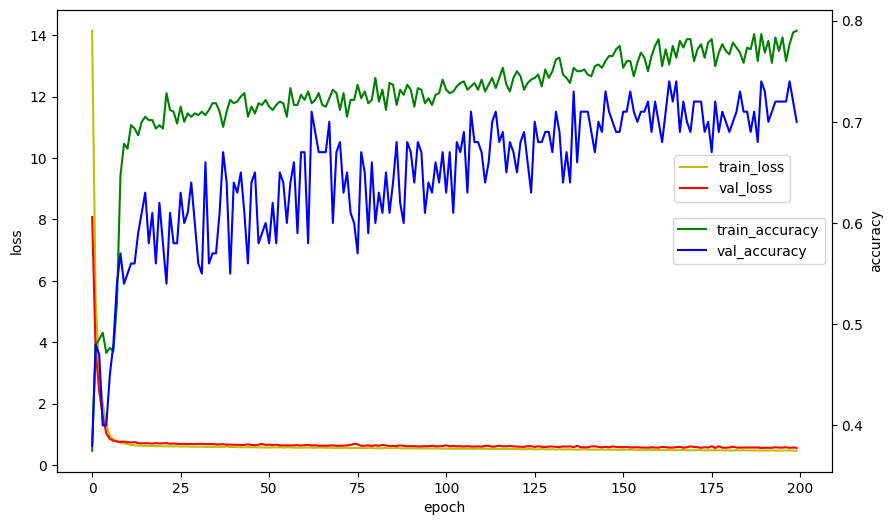

In [67]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [68]:
# 모델 평가
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 0s/step - loss: 0.6271 - accuracy: 0.7206


[0.6271273493766785, 0.720588207244873]

In [69]:
#혼동행렬(교차표) - 원핫인코딩 복구
# y_test : 실제값
y_hat = model.predict(X_test).argmax(axis=1) #최대값의 열 인덱스를 가져와 (def: axis=0. 최대값 행)

3/3 [==============================] - 0s 2ms/step


In [70]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1
실제값,,
0.0,39,2
1.0,17,10


In [71]:
confusion_matrix(y_test, y_hat)

array([[39,  2],
       [17, 10]], dtype=int64)

## 2.6. 모델 사용하기

In [72]:
X_test[0]

array([  2.   , 122.   ,  76.   ,  27.   , 200.   ,  35.9  ,   0.483,
        26.   ])

In [76]:
pred = model.predict(X_test[0].reshape(-1, 8)) #2차원으로 넣어
pred.argmax(axis=1)

1/1 [==============================] - 0s 17ms/step


array([0], dtype=int64)